In [2]:
from sklearn.linear_model import MultiTaskLasso, MultiTaskLassoCV
from sklearn.metrics import mean_squared_error
from custom_functions import processing
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [3]:
# import data
file_path = 'P:\DATA_OCT_22\Expert_Eye\Dataset\Data\data_v10.xlsx'
dataset = pd.read_excel(file_path)
dataset = dataset.drop(['Foldername'], axis=1)
dataset.head()

,Gender,VINCQ32DDN,VINICODEX003,FROPCOM0001,FROPCOM0005,FROPCOM0006_S1_,FROPCOM0006_S2_,FROPCOM0006_S3_,FROPCOM0006_S4_,FROPCOM0006_S5_,...,Item_1,Item_2,Item_3,Item_4,Item_5,grip,Frailty_Score,Frailty_State,Fried_Score,Fried_State
0,0,76.0,0.0,0.0,3.0,NaN,NaN,NaN,NaN,1.0,...,0.0,1,1.0,1.0,NaN,NaN,5,1,3,1
1,0,75.0,1.0,2.0,3.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0,1.0,1.0,1.0,21.5,4,1,3,1
2,0,67.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0,0.0,1.0,1.0,23.2,9,0,2,0
3,0,72.0,1.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,...,0.0,1,0.0,0.0,1.0,17.7,7,0,2,0
4,1,69.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0,0.0,0.0,1.0,40.0,8,0,1,0


In [5]:
# Features and Target
X = dataset.drop(['Fried_State','Fried_Score','Frailty_State','Frailty_Score'], axis=1).values

# The two tasks are Fried_State and Frailty_State
y = dataset[['Frailty_Score','Fried_Score']].values

# drop the rows with missing values in the target variable y




In [7]:

models = {
    'Lasso': MultiTaskLasso(),
    #'ElasticNet': MultiTaskElasticNet()
}

params = {
    'Lasso': {
        'alpha': [0.1, 1, 10],
        'max_iter': [1000],
        
    },

    'ElasticNet': {
        'alpha': [0.1, 1, 10],
        'max_iter': [1000],
    },

}


In [8]:
n_splits = 5
scaler_y1 = MinMaxScaler()
scaler_y2 = MinMaxScaler()
# Initialize lists to store RMSE for each task across folds
rmse_task1_list = []
rmse_task2_list = []

# Initialize variables to store the best model and best score
best_overall_model = None
best_overall_score = float('-inf')  # Initialize with negative infinity

kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

# Loop through each Fold
for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # Impute missing values on train set
    X_train_imputed, best_k = processing(X_train, n_splits=n_splits, k_values=[1, 3, 5, 7, 9], verbose=False)

    X_test_imputed, best_k = processing(X_test, n_splits=n_splits, k_values=[1, 3, 5, 7, 9], verbose=False)


    # Scale data
    scaler = MinMaxScaler()
    X_train_scaled = scaler.fit_transform(X_train_imputed)
    X_test_scaled = scaler.transform(X_test_imputed)

    # Scale target for each task
    y_train_task1 = y_train[:, 0].reshape(-1, 1)
    y_train_task2 = y_train[:, 1].reshape(-1, 1)

    y_test_task1 = y_test[:, 0].reshape(-1, 1)
    y_test_task2 = y_test[:, 1].reshape(-1, 1)

    y_train_task1_scaled = scaler_y1.fit_transform(y_train_task1)
    y_train_task2_scaled = scaler_y2.fit_transform(y_train_task2)

    y_test_task1_scaled = scaler_y1.transform(y_test_task1)
    y_test_task2_scaled = scaler_y2.transform(y_test_task2)
    
    y_train_scaled = np.column_stack((y_train_task1_scaled, y_train_task2_scaled))
    y_test_scaled = np.column_stack((y_test_task1_scaled, y_test_task2_scaled))

    # Initialize variables to store the best RMSE for each task in this fold
    best_rmse_task1 = float('inf')  # Initialize with positive infinity
    best_rmse_task2 = float('inf')  # Initialize with positive infinity

    model = MultiTaskLassoCV(cv=5).fit(X_train_scaled, y_train_scaled)

    print(model.coef_)

    # sort the coefficients
    sorted_coef_index = model.coef_.argsort()





    # Loop through each model
    for model_name, model in models.items():
        print(f'Training {model_name}...')

        # Grid search
        grid_search = GridSearchCV(model, params[model_name], cv=5, verbose=0, scoring='neg_mean_squared_error', n_jobs=-1)

        # Fit model
        grid_search.fit(X_train_scaled, y_train_scaled)

        # Check if this model is better than the current best
        current_best_score = grid_search.best_score_

        if current_best_score > best_overall_score:
            best_overall_score = current_best_score
            best_overall_model = grid_search.best_estimator_

        # Predict
        y_pred_scaled = grid_search.predict(X_test_scaled)

        # Inverse scale
        y_pred_task1 = scaler_y1.inverse_transform(y_pred_scaled[:, 0].reshape(-1, 1))
        y_pred_task2 = scaler_y2.inverse_transform(y_pred_scaled[:, 1].reshape(-1, 1))

        y_pred = np.column_stack((y_pred_task1, y_pred_task2))

        # Calculate and store RMSE
        rmse_task1 = mean_squared_error(y_test_task1, y_pred_task1, squared=False)
        rmse_task2 = mean_squared_error(y_test_task2, y_pred_task2, squared=False)

        best_rmse_task1 = min(best_rmse_task1, rmse_task1)
        best_rmse_task2 = min(best_rmse_task2, rmse_task2)
        
    # Append RMSE for each task to list
    rmse_task1_list.append(best_rmse_task1)
    rmse_task2_list.append(best_rmse_task2)





# Print best model and best score
print("Best overall model:", best_overall_model)
print("Best overall score:", best_overall_score)

# Calculate average RMSE across folds
avg_rmse_task1 = np.mean(rmse_task1_list)
std_rmse_task1 = np.std(rmse_task1_list, ddof=1)

avg_rmse_task2 = np.mean(rmse_task2_list)
std_rmse_task2 = np.std(rmse_task2_list, ddof=1)

print(f'Average RMSE for task 1 across all folds: {avg_rmse_task1}, std: {std_rmse_task1}')
print(f'Average RMSE for task 2 across all folds: {avg_rmse_task2}, std: {std_rmse_task2}')

[[ 0.0282762  -0.18155301  0.01381911 ... -0.00438347 -0.01273398
   0.        ]
 [ 0.00039961  0.02518239  0.00204855 ...  0.16888241  0.19670412
   0.        ]]
Training Lasso...
[[ 0.04538271 -0.04389397  0.         ...  0.03760842  0.02684671
   0.        ]
 [-0.01005047 -0.00589138  0.         ...  0.12739522  0.15262714
   0.        ]]
Training Lasso...
[[ 0.02014105 -0.01647704  0.         ... -0.00123243  0.0482594
   0.        ]
 [-0.01314043  0.00113777  0.         ...  0.11414015  0.14444441
   0.        ]]
Training Lasso...
[[ 0.01810029 -0.0800849   0.         ...  0.00383235  0.01084504
   0.        ]
 [-0.00153393  0.00695054  0.         ...  0.12614675  0.19350776
   0.        ]]
Training Lasso...
[[ 0.01235387  0.          0.         ... -0.00146703  0.07319367
   0.        ]
 [-0.00288833  0.          0.         ...  0.05119798  0.1464521
   0.        ]]
Training Lasso...
Best overall model: MultiTaskLasso(alpha=0.1)
Best overall score: -0.06081023588194971
Average RM

In [10]:
W = grid_search.best_estimator_.coef_
print(f'Weight :' , W)
np.array(W).shape

Weight : [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


(2, 817)

In [12]:
# filter W, only keep the non-zero coefficients
W_nonzero = W[W != 0]
print(f'Non-zero Weight :' , W_nonzero)
np.array(W_nonzero).shape


Non-zero Weight : []


(0,)

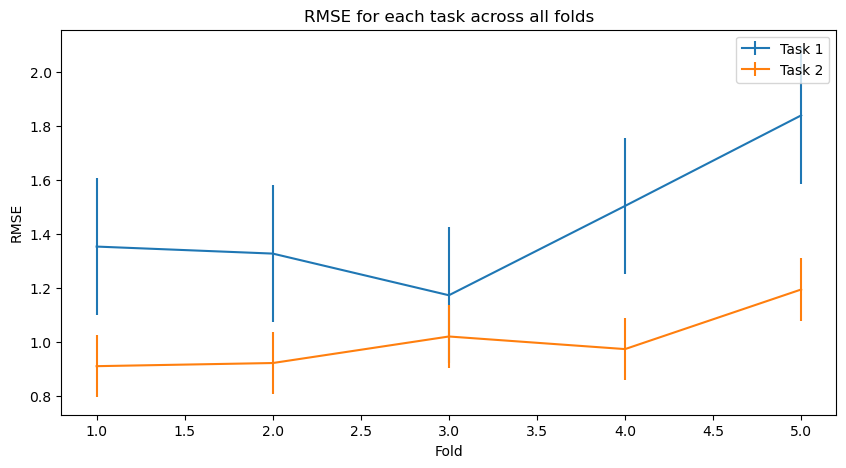

In [6]:
# Plot RMSE for each task across all the number of folds
plt.figure(figsize=(10, 5))
plt.errorbar(range(1, len(rmse_task1_list) + 1), rmse_task1_list, yerr=std_rmse_task1, label='Task 1')
plt.errorbar(range(1, len(rmse_task2_list) + 1), rmse_task2_list, yerr=std_rmse_task2, label='Task 2')

plt.xlabel('Fold')
plt.ylabel('RMSE')
plt.title('RMSE for each task across all folds')
plt.legend()
plt.show()




In [7]:
print("Length of rmse_task1_list:", len(rmse_task1_list))
print("Length of rmse_task2_list:", len(rmse_task2_list))


Length of rmse_task1_list: 5
Length of rmse_task2_list: 5


In [8]:
# Number of features selected
print(f'Number of features selected: {best_overall_model.coef_.shape[1]}')

# Number of features with non-zero coefficients
print(f'Number of features with non-zero coefficients: {np.count_nonzero(best_overall_model.coef_)}')

# Number of features seen during training
print(f'Number of features seen during training: {best_overall_model.n_features_in_}')



Number of features selected: 169
Number of features with non-zero coefficients: 0
Number of features seen during training: 169
